In [1]:
import warnings, os, re, math, smopy, ast, pycrs, collections, dill, pickle, random
import numpy as np
import pandas as pd
import seaborn as sns
#import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from numpy.random import randint
from simpledbf import Dbf5
from matplotlib.colors import LogNorm
from statistics import mean
from collections import Counter, defaultdict
from tqdm import tqdm
from copy import deepcopy
from math import pi
from pathlib import Path
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy import stats
random.seed()
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

filepath = "../data/"
resultpath = "../results/"
logpath = "../logs/"


In [2]:
with open(f'{logpath}kmeans_resubmission.txt','r') as f:
    results_km = f.read().split('\n')

In [3]:
with open(f'{logpath}bigm_resubmission.txt','r') as f:
    results_milp = f.read().split('\n')

In [4]:
with open(f'{logpath}lr_resubmission.txt','r') as f:
    results_lr = f.read().split('\n')

In [5]:
MAXK = 5
MAXF = 5
def gen_maemse(results):
    mses = defaultdict(dict)
    maes = defaultdict(dict)
    for i in range(len(results)):
        if 'feature:' in results[i] and 'MAE' in results[i+1]:
            r = results[i].split(' ')
            k = int(r[0])
            f = int(r[2])
            if k <= MAXK and f <= MAXF:
                maes[k][f] = float(results[i+1].split(' ')[1])
                mses[k][f] = float(results[i+2].split(' ')[1])
    return (pd.DataFrame(maes),pd.DataFrame(mses))

In [6]:
(maes_km, mses_km) = gen_maemse(results_km)

In [7]:
(maes_milp, mses_milp) = gen_maemse(results_milp)

In [8]:
(maes_lr, mses_lr) = gen_maemse(results_lr)

In [9]:
maes_milp.shape[0]

4

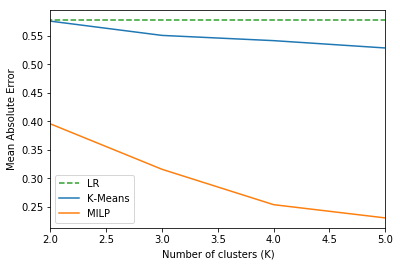

In [10]:
makm, = plt.plot(maes_km.mean(axis=0),label='K-Means')
milp, = plt.plot(maes_milp.mean(axis=0),label='MILP')
malr, = plt.plot(np.asarray([maes_lr.mean(axis=0).values[0] for t in range(6)]),label='LR',linestyle='dashed')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Mean Absolute Error')
plt.xlim([2,5])
plt.legend(handles=[malr,makm,milp],loc='lower left')
plt.savefig(f'{resultpath}kmeans/mae_all.pdf',dpi=300)

../results/kmeans/mse_all.pdf


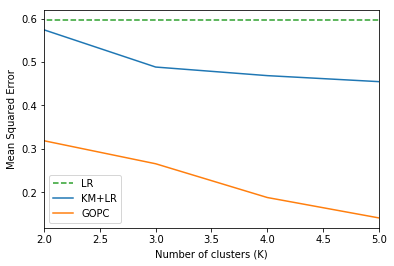

In [11]:
makm, = plt.plot(mses_km.iloc[3,:],label='KM+LR')
milp, = plt.plot(mses_milp.iloc[3,:],label='GOPC')
malr, = plt.plot(np.asarray([mses_lr.mean(axis=0).values[0] for t in range(6)]),label='LR',linestyle='dashed')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Mean Squared Error')
plt.xlim([2,5])
plt.legend(handles=[malr,makm,milp],loc='lower left')
plt.savefig(f'{resultpath}kmeans/mse_all.pdf')
print(f'{resultpath}kmeans/mse_all.pdf')

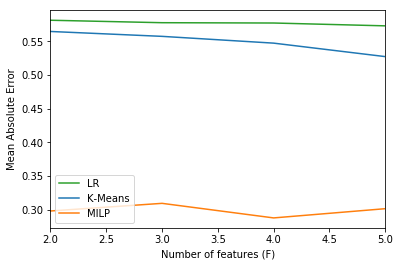

In [12]:
makm, = plt.plot(maes_km.mean(axis=1),label='K-Means')
milp, = plt.plot(maes_milp.mean(axis=1),label='MILP')
malr, = plt.plot(maes_lr.mean(axis=1),label='LR')
plt.xlabel('Number of features (F)')
plt.ylabel('Mean Absolute Error')
plt.xlim([2,5])
plt.legend(handles=[malr,makm,milp],loc='lower left')
plt.savefig(f'{resultpath}kmeans/mae_f_all.pdf',dpi=300)

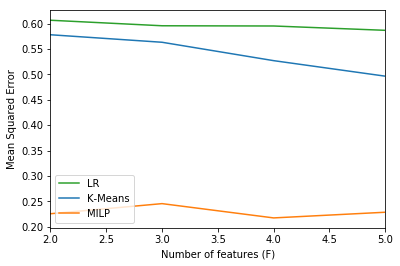

In [13]:
makm, = plt.plot(mses_km.mean(axis=1),label='K-Means')
milp, = plt.plot(mses_milp.mean(axis=1),label='MILP')
malr, = plt.plot(mses_lr.mean(axis=1),label='LR')
plt.xlabel('Number of features (F)')
plt.ylabel('Mean Squared Error')
plt.xlim([2,5])
plt.legend(handles=[malr,makm,milp],loc='lower left')
plt.savefig(f'{resultpath}kmeans/mse_f_all.pdf',dpi=300)

In [14]:
def pdargmax(df):
    t = df.values
    return np.unravel_index(t.argmax(), shape=t.shape) + np.asarray([2,2])

In [15]:
best = defaultdict(dict)
best['MAE']['LR'] = pdargmax(maes_lr)
best['MAE']['K-Means'] = pdargmax(maes_km)
best['MAE']['MILP'] = pdargmax(maes_milp)
best['MSE']['LR'] = pdargmax(mses_lr)
best['MSE']['K-Means'] = pdargmax(mses_km)
best['MSE']['MILP'] = pdargmax(mses_lr)

In [16]:
pd.DataFrame(best)

,MAE,MSE
K-Means,"[2, 2]","[2, 2]"
LR,"[2, 2]","[2, 2]"
MILP,"[3, 2]","[2, 2]"


In [17]:
best = defaultdict(dict)
best['MAE']['LR'] = pdargmax(maes_lr),"%.2f" % (maes_lr.max().max())
best['MAE']['K-Means'] = pdargmax(maes_km),"%.2f" % (maes_km.max().max())
best['MAE']['MILP'] = pdargmax(maes_milp),"%.2f" % (maes_milp.max().max())
best['MSE']['LR'] = pdargmax(mses_lr),"%.2f" % (mses_lr.max().max())
best['MSE']['K-Means'] = pdargmax(mses_km),"%.2f" % (mses_km.max().max())
best['MSE']['MILP'] = pdargmax(mses_milp),"%.2f" % (mses_milp.max().max())
pd.DataFrame(best)

,MAE,MSE
K-Means,"([2, 2], 0.58)","([2, 2], 0.61)"
LR,"([2, 2], 0.58)","([2, 2], 0.61)"
MILP,"([3, 2], 0.41)","([3, 2], 0.37)"


In [18]:
mses_lr[1][5], maes_lr[1][5]

(0.5869419680356015, 0.5731766865563942)

In [19]:
mkm = pd.DataFrame(maes_km.iloc[3,:])

In [20]:
mmp = pd.DataFrame(maes_milp.iloc[3,:])

In [21]:
mkm['method'] = 'KM'

In [22]:
mmp['method'] = 'PC'

In [23]:
mmp['MAE'] = mmp[5]

In [24]:
mmp = mmp.drop(5,axis=1)

In [25]:
mkm['MAE'] = mkm[5]

In [26]:
mkm = mkm.drop(5,axis=1)

In [27]:
maeres = pd.concat([mmp,mkm])

In [28]:
maeres['K'] = maeres.index
maeres = maeres[['K','method','MAE']]
maeres = maeres.sort_index()

In [29]:
mkm = pd.DataFrame(mses_km.iloc[3,:])

mmp = pd.DataFrame(mses_milp.iloc[3,:])

mkm['method'] = 'KM'

mmp['method'] = 'PC'

mmp['MSE'] = mmp[5]

mmp = mmp.drop(5,axis=1)

mkm['MSE'] = mkm[5]

mkm = mkm.drop(5,axis=1)

mseres = pd.concat([mmp,mkm])

mseres['K'] = mseres.index
mseres = mseres[['K','method','MSE']]
mseres = mseres.sort_index()

In [30]:
mseres

,K,method,MSE
2,2,PC,0.318714
2,2,KM,0.574169
3,3,PC,0.265731
3,3,KM,0.488479
4,4,PC,0.187991
4,4,KM,0.468727
5,5,PC,0.140992
5,5,KM,0.454878


In [31]:
final = pd.merge(mseres,maeres, left_on=['K','method'],right_on=['K','method'])
final = final.round(2)

In [32]:
print(final.to_latex(index=False))

\begin{tabular}{rlrr}
\toprule
 K & method &   MSE &   MAE \\
\midrule
 2 &     PC &  0.32 &  0.39 \\
 2 &     KM &  0.57 &  0.57 \\
 3 &     PC &  0.27 &  0.34 \\
 3 &     KM &  0.49 &  0.53 \\
 4 &     PC &  0.19 &  0.25 \\
 4 &     KM &  0.47 &  0.51 \\
 5 &     PC &  0.14 &  0.22 \\
 5 &     KM &  0.45 &  0.50 \\
\bottomrule
\end{tabular}



In [33]:
print("1 & LR & %.2f & %.2f \\\\" % (mses_lr[1][5], maes_lr[1][5]))

1 & LR & 0.59 & 0.57 \\
